# Getting started with TinyTimeMixer (TTM) with Channel-Mix Finetuning

This notebooke demonstrates the usage of finetuning a pre-trained `TinyTimeMixer` model with channel-mix finetuning. In channel-mix finetuning, we forecast the target_values based on the past values of the target columns and conditional columns and mixing them.


For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Fine-tune**: The pre-trained TTM will be quickly fine-tuned onthe `train` split of the target data, and subsequently, evaluated on the `test` part of the target data. During finetuing, we used the values mentioned in `conditional_columns` as features for channel mixing. Search for `# ch_mix:` keyword for important parameters to edit for channel mixing finetuning. Set decoder_mode to "mix_channel" for channel-mix finetuning.


Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

## Installation

In [ ]:
# Install the tsfm library
# ! pip install "granite-tsfm[notebooks] @ git+ssh://git@github.com/ibm-granite/granite-tsfm.git"

## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

## Important arguments

In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "bike_sharing"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/blobibob/bike-sharing-dataset/main/hour.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"


# Forecasting parameters
context_length = 512
forecast_length = 96

## Data processing pipeline

In [3]:
# Load the data file and see the columns

timestamp_column = "dteday"
# timestamp_column = "timestamp"
id_columns = []


data = pd.read_csv(
    DATA_ROOT_PATH,
    parse_dates=[timestamp_column],
)


data[timestamp_column] = pd.to_datetime(data[timestamp_column])

# Reset the index to ensure the hours are correctly assigned, as hour information is missing in the original timestamp of this df
data[timestamp_column] = data[timestamp_column] + pd.to_timedelta(
    data.groupby(data[timestamp_column].dt.date).cumcount(), unit="h"
)


print(data)
# data = pd.read_csv(
#     "/dccstor/tsfm23/datasets/exogs_expts/bike_sharing_dataset/processed_data/bike_sharing_hourly_processed.csv",
#     # parse_dates=[timestamp_column],
# )

# print(data)

# exog: Mention Exog channels in control_columns and target in target_columns

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": ["casual", "registered", "cnt"],
    "conditional_columns": [
        "season",
        "yr",
        "mnth",
        "holiday",
        "weekday",
        "workingday",
        "weathersit",
        "temp",
        "atemp",
        "hum",
        "windspeed",
    ],
}

split_params = {"train": [0, 0.5], "valid": [0.5, 0.75], "test": [0.75, 1.0]}

       instant              dteday  season  yr  mnth  hr  holiday  weekday  \
0            1 2011-01-01 00:00:00       1   0     1   0        0        6   
1            2 2011-01-01 01:00:00       1   0     1   1        0        6   
2            3 2011-01-01 02:00:00       1   0     1   2        0        6   
3            4 2011-01-01 03:00:00       1   0     1   3        0        6   
4            5 2011-01-01 04:00:00       1   0     1   4        0        6   
...        ...                 ...     ...  ..   ...  ..      ...      ...   
17374    17375 2012-12-31 19:00:00       1   1    12  19        0        1   
17375    17376 2012-12-31 20:00:00       1   1    12  20        0        1   
17376    17377 2012-12-31 21:00:00       1   1    12  21        0        1   
17377    17378 2012-12-31 22:00:00       1   1    12  22        0        1   
17378    17379 2012-12-31 23:00:00       1   1    12  23        0        1   

       workingday  weathersit  temp   atemp   hum  windspeed  c

In [4]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    data,
    split_params,
)

In [5]:
train_dataset[3]

{'past_values': tensor([[-0.6590, -0.9606, -0.9771,  ..., -1.0206,  0.5452, -1.5526],
         [-0.7363, -1.0429, -1.0669,  ..., -1.0206,  0.5452, -1.5526],
         [-0.7363, -1.0429, -1.0669,  ..., -1.1921,  0.5452, -0.8262],
         ...,
         [-0.1692, -0.3475, -0.3334,  ..., -1.8780, -1.0844,  0.2626],
         [-0.1176, -0.2102, -0.2061,  ..., -1.9640, -1.3899,  2.1987],
         [-0.4270, -0.3658, -0.4232,  ..., -2.0494, -1.5936,  1.5939]]),
 'future_values': tensor([[-0.2981, -0.2011, -0.2510,  ...,  0.0000,  0.0000,  0.0000],
         [-0.4012, -0.4665, -0.4980,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5043, -0.5397, -0.5878,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.6847, -0.7227, -0.7899,  ...,  0.0000,  0.0000,  0.0000],
         [-0.7105, -0.6861, -0.7675,  ...,  0.0000,  0.0000,  0.0000],
         [-0.4785, -0.4116, -0.4756,  ...,  0.0000,  0.0000,  0.0000]]),
 'past_observed_mask': tensor([[True, True, True,  ..., True, True, True],
         

## Zero-shot evaluation method

In [6]:
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"

zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)
zeroshot_model

INFO:p-2610988:t-22493558117120:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r1
INFO:p-2610988:t-22493558117120:get_model.py:get_model:Selected prediction_length = 96
INFO:p-2610988:t-22493558117120:get_model.py:get_model:Model loaded successfully!
INFO:p-2610988:t-22493558117120:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96


TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0): TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
                    

In [7]:
tsp.prediction_channel_indices

[0, 1, 2]

In [8]:
tsp.num_input_channels

14

In [9]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)

In [10]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.9891365170478821,
 'eval_model_preparation_time': 0.0025,
 'eval_runtime': 4.5876,
 'eval_samples_per_second': 926.406,
 'eval_steps_per_second': 14.605}

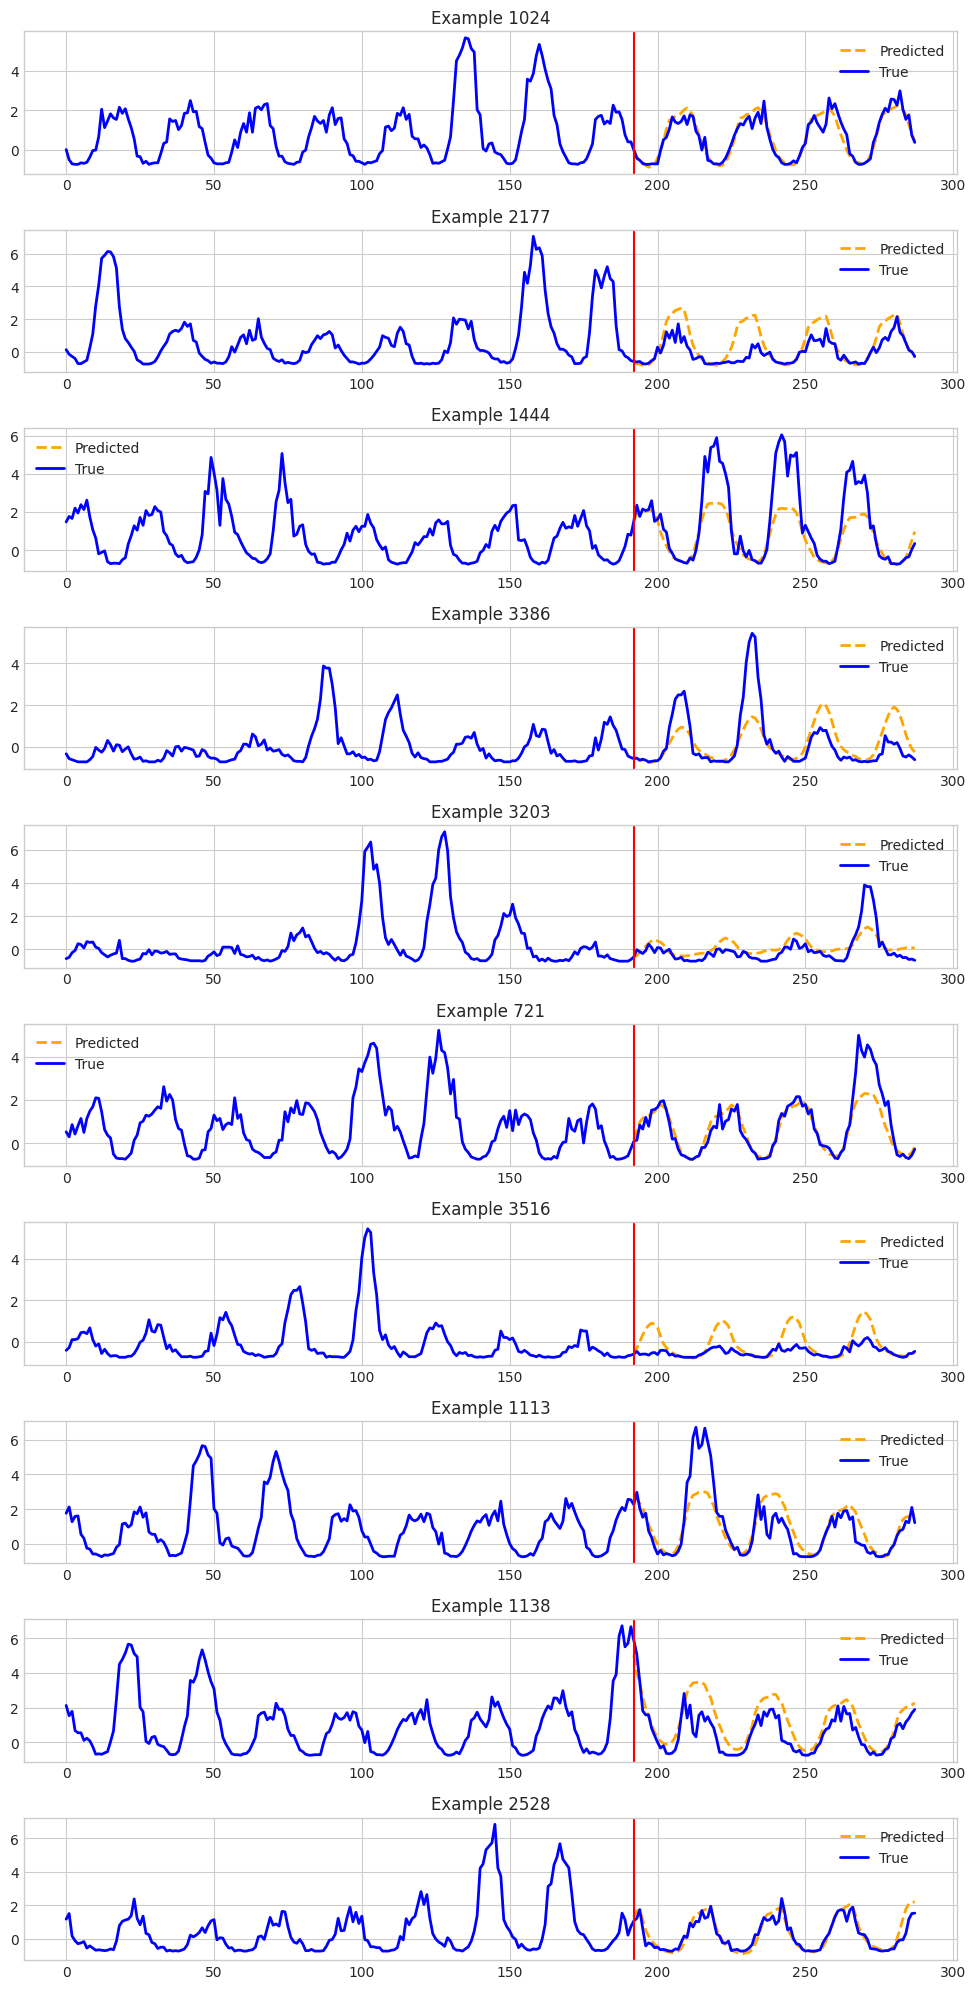

In [11]:
# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "bike_sharing"),
    plot_prefix="test_zeroshot",
    channel=0,
)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [13]:
finetune_forecast_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # ch_mix:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
)
finetune_forecast_model

INFO:p-2610988:t-22493558117120:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r1
INFO:p-2610988:t-22493558117120:get_model.py:get_model:Selected prediction_length = 96
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r1 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_featu

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0): TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
                    

### Frezze the TTM backbone

In [14]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 807864
Number of params after freezing the backbone 292280


### Finetune model with decoder mixing and exog fusion

In [15]:
# Important parameters
num_epochs = 50  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

learning_rate, finetune_forecast_model = optimal_lr_finder(
    finetune_forecast_model,
    train_dataset,
    batch_size=batch_size,
    enable_prefix_tuning=False,
)
print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

INFO:p-2610988:t-22493558117120:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-2610988:t-22493558117120:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.
INFO:p-2610988:t-22493558117120:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 0.0006280291441834253


OPTIMAL SUGGESTED LEARNING RATE = 0.0006280291441834253


In [16]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

/dccstor/tsfm-irl/conda_envs/envs/tsfmvj/lib/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Using learning rate = 0.0006280291441834253


Epoch,Training Loss,Validation Loss
1,0.480400,0.742008
2,0.433700,0.689324
3,0.412900,0.658833
4,0.394000,0.639458
5,0.374900,0.622839
6,0.359600,0.608136
7,0.347600,0.586700
8,0.338000,0.577171
9,0.329500,0.572785
10,0.321000,0.555237


[TrackingCallback] Mean Epoch Time = 3.118059678511186 seconds, Total Train Time = 90.19373106956482


TrainOutput(global_step=2794, training_loss=0.32229474107964856, metrics={'train_runtime': 90.198, 'train_samples_per_second': 4480.146, 'train_steps_per_second': 70.401, 'total_flos': 6177731509813248.0, 'train_loss': 0.32229474107964856, 'epoch': 22.0})

In [17]:
finetune_forecast_trainer.evaluate(test_dataset)

{'eval_loss': 0.6489244103431702,
 'eval_runtime': 0.977,
 'eval_samples_per_second': 4350.06,
 'eval_steps_per_second': 68.577,
 'epoch': 22.0}

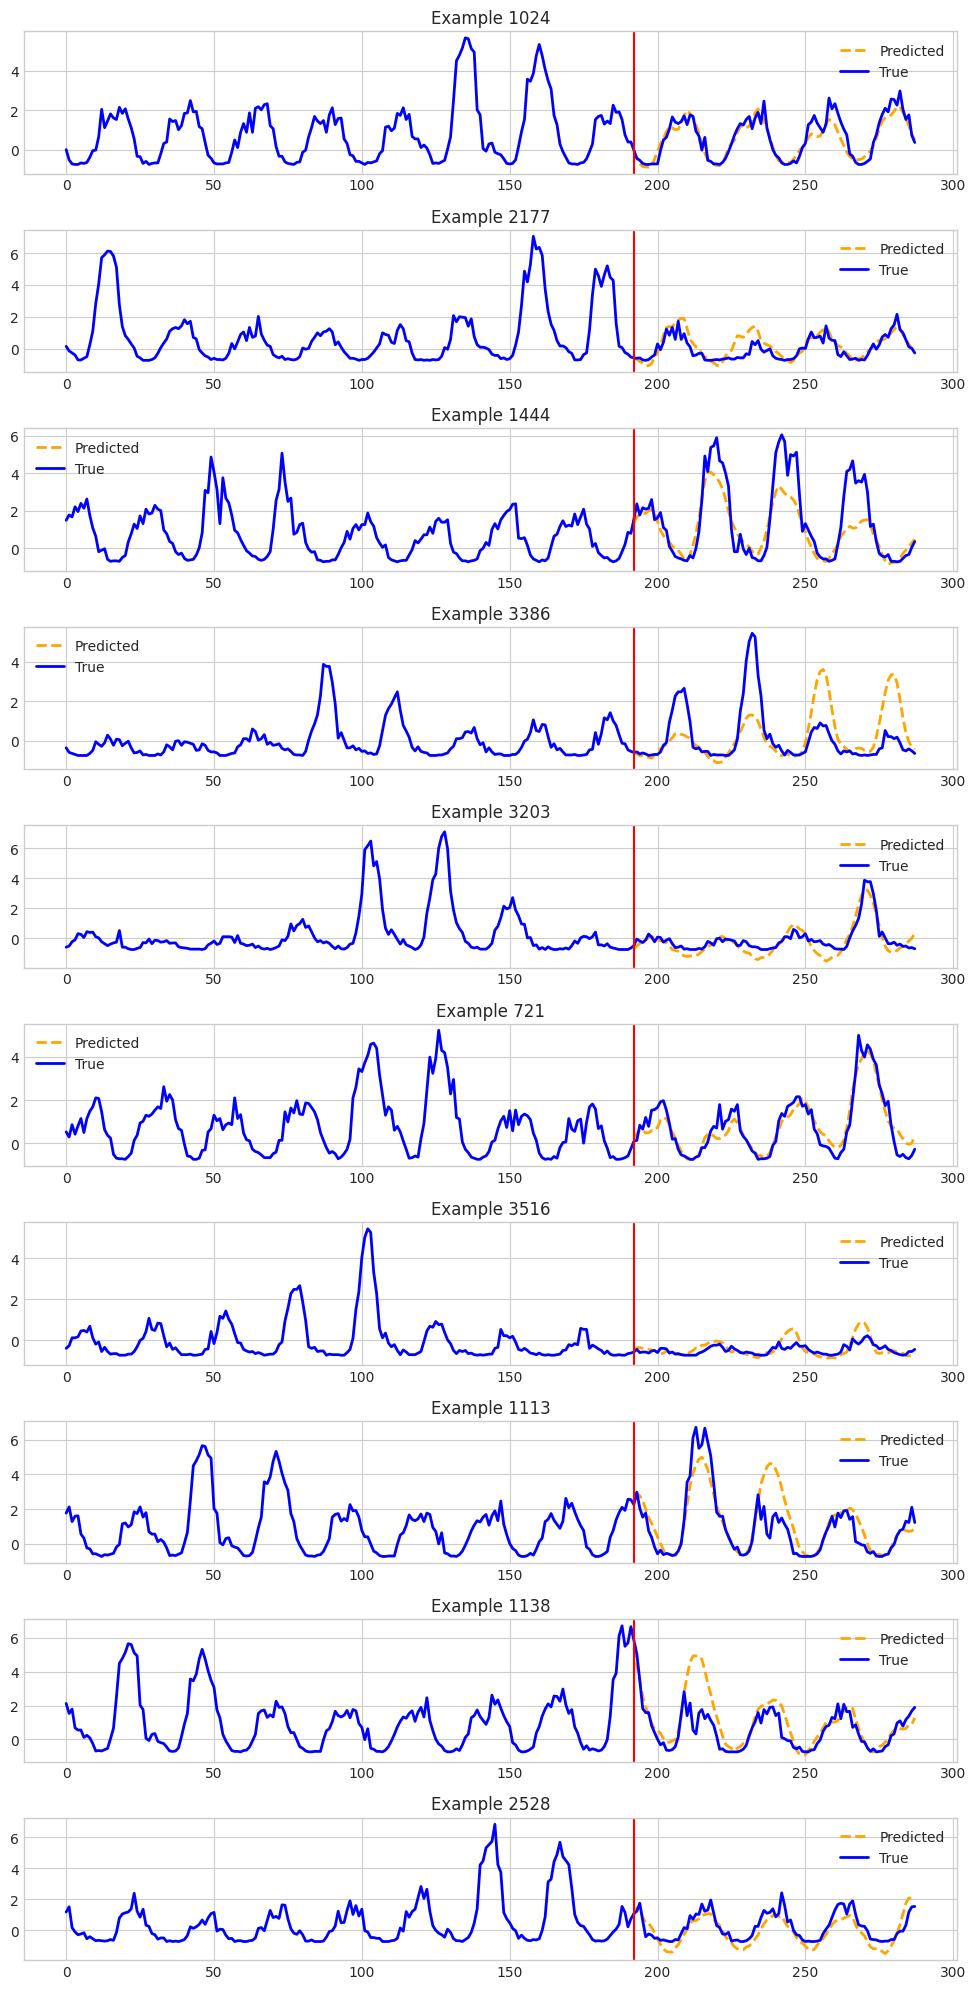

In [18]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "bike_sharing"),
    plot_prefix="test_finetune",
    channel=0,
)